In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


metrics = ['f1_cd','f1_ln']
mappings = ['incremental','procrustes','twec']
w2vec_algorithms = ['cbow','sgns','lda2vec']
embeddings = ['pretrained','None']
results_path = './output/**/**/results'



results_df = pd.DataFrame()

# retrieve results from pickle files
path = '../output/**/**/results'
text_files = set(glob.glob(path + "/**/*.pkl", recursive=True))
for file in text_files:
    results_df = pd.concat([results_df, pd.read_pickle(file)], ignore_index=True, axis=0)

# save to csv
results_df.to_csv('../language_drift_results', index=False)

results_df = pd.read_csv('../language_drift_results')

# remove unnecessary columns
results_df = results_df.drop(['precision_cd','precision_ln','f1_cd','f1_ln',
          'recall_cd','recall_ln','data_set_id','dim','window_size','t'],axis=1)

print(results_df.head())

  w2vec_algorithm pretrained      mapping  accuracy_ln language  accuracy_cd
0            sgns       None  incremental     0.575000      lat          NaN
1            cbow      glove  incremental     0.540541       en          NaN
2            sgns       None   procrustes     0.525000      lat          NaN
3            cbow       None         twec     0.625000      lat          NaN
4            sgns       None         twec     0.513514       en          NaN


In [4]:
# deep copy
model_df = results_df.copy(deep=True)

# remove word2vec "pretrained" executions 
# since lda2vec does not contain exections with pretrained
#model_df = model_df.drop(model_df[((model_df['pretrained'] != 'None') )].index)
                                         
# remove unnecessary columns
#model_df = model_df.drop(['pretrained'],axis=1)

# 'f1_cd','f1_ln' columns to row info into the newly created metric column
model_df = model_df.melt(id_vars=["language", "w2vec_algorithm","mapping","pretrained"], var_name="metric", value_name="accuracy_score")

# remove rows with Nan values at f1_scores 
# it stands for the execution of e.g 'f1_cd' where 'f1_ln' was Nan 
model_df = model_df[model_df['accuracy_score'].notna()]

print("model_df_1: ",model_df)

# transform cbow/sgns to word2vec
#model_df["w2vec_algorithm"] = np.where(model_df["w2vec_algorithm"] == "lda2vec", 'lda2vec', 'word2vec')

print("model_df_2: ",model_df)



print(model_df)
# save to csv
model_df.to_csv('../language_drift_results', index=False)

model_df_1:      language w2vec_algorithm      mapping  pretrained       metric  \
0        lat            sgns  incremental        None  accuracy_ln   
1         en            cbow  incremental       glove  accuracy_ln   
2        lat            sgns   procrustes        None  accuracy_ln   
3        lat            cbow         twec        None  accuracy_ln   
4         en            sgns         twec        None  accuracy_ln   
..       ...             ...          ...         ...          ...   
157      lat            sgns   procrustes        None  accuracy_cd   
161       en            cbow  incremental        None  accuracy_cd   
163      swe            cbow  incremental        None  accuracy_cd   
166       de            sgns         twec        None  accuracy_cd   
167      lat            sgns  incremental  latconll17  accuracy_cd   

     accuracy_score  
0          0.575000  
1          0.540541  
2          0.525000  
3          0.625000  
4          0.513514  
..            

## Research Questions
### 1. Which vectors' alignment method performs better?

### Null Hypothesis: 
Αll mapping methods we investigate(‘procrustes’, ‘incremental’, ‘twec’) perform equally across different executions on the same datasets and parameters.


In [73]:
# deep copy
mapping_df = results_df.copy(deep=True)

# remove "lda2vec":     there are no execution with all alignment methods, only procrustes
# remove "pretrained": there are no executions with pretrained embeddings and "TWEC" method
mapping_df = mapping_df.drop(mapping_df[((mapping_df['pretrained'] != 'None') 
                                         | (mapping_df['w2vec_algorithm'] == 'lda2vec'))].index)
                                         
# remove pretrained column
mapping_df = mapping_df.drop(['pretrained'],axis=1)

mapping_df = mapping_df.melt(id_vars=["language", "w2vec_algorithm","mapping"], 
        var_name="metric", 
        value_name="accuracy_score")


# remove rows with Nan values at f1_scores 
mapping_df = mapping_df[mapping_df['accuracy_score'].notna()]

# remove unnecessary columns
mapping_df = mapping_df.drop('metric',axis=1)

print(mapping_df.count(),"\n")
print(mapping_df.head())

language           48
w2vec_algorithm    48
mapping            48
accuracy_score     48
dtype: int64 

  language w2vec_algorithm      mapping  accuracy_score
0      lat            cbow         twec        0.575000
1      lat            sgns  incremental        0.275000
2       en            sgns   procrustes        0.486486
4       de            cbow  incremental        0.354167
5       en            cbow   procrustes        0.378378


### 1.1 Shapiro-Wilk Test (checks normality of distribution)

In [75]:
# Shapiro-Wilk test
from collections import defaultdict
from scipy import stats

alpha =0.05

print("Shapiro-Wilk test for normal distribution: \n")
mapping_normality_dict = defaultdict()
for mapping in mappings:
    stat, p = stats.shapiro( mapping_df.loc[mapping_df['mapping'] == str(mapping),'accuracy_score'])
    print(mapping)
    if p >= alpha:
        print("\t has a normal distribution with pvalue = "+ str(p) + ", stat=",str(stat))
        mapping_normality_dict[mapping] = True
    else:
        print("\t has NOT a normal distribution with pvalue = ", p, "stat=",stat)
        mapping_normality_dict[mapping] = False

Shapiro-Wilk test for normal distribution: 

incremental
	 has a normal distribution with pvalue = 0.7972479462623596, stat= 0.9675336480140686
procrustes
	 has a normal distribution with pvalue = 0.7031615972518921, stat= 0.9622721672058105
twec
	 has a normal distribution with pvalue = 0.44314199686050415, stat= 0.9469621181488037


### Normality Results
**Incremental** and **twec** method can be described by the normal distribution.

However since **procrustes** method does not meet the criteria of the normality <u>we have to go through with non parapetric tests.</u>

### 1.2 Kruskal Wallis Test(non parametric - normality is not a prerequisite)
* Prerequisites (non normal distributions, more than two groups)
* H0: Populations have same distributions


In [76]:
# Compare groups of incremental, procrustes and twec

alpha =0.05

print("Kruskal Wallis H-test: ")
stat, p = stats.kruskal(
    mapping_df.loc[mapping_df['mapping'] == 'incremental','accuracy_score'],
    mapping_df.loc[mapping_df['mapping'] == 'procrustes','accuracy_score'],
    mapping_df.loc[mapping_df['mapping'] == 'twec','accuracy_score'])

if p >= alpha:
    print("    Same distributions (fail to reject H0) with pvalue = ",p, "stat=",stat)
else:
    print("    Different distributions (reject H0) = ", p, "stat=",stat)



Kruskal Wallis H-test: 
    Same distributions (fail to reject H0) with pvalue =  0.11063424847070434 stat= 4.403051154306856


### 1.3 Wilcoxon Signed-Rank Test (non parametric - normality is not a prerequisite)
* Prerequisites (non normal distributions, paired samples, two populations)
* Samples are **paired** since all variables except the under investigation variable are shared among the different populations
* H0: Populations have same distributions


In [77]:
# Wilcoxon Signed-Rank Test (non parametric - normality is not a prerequisite)
# Compare groups of incremental, procrustes and twec

alpha =0.05

print("Wilcoxon Signed-Rank H-test: \n\n incremental-procrustes")
stat, p = stats.wilcoxon(
    mapping_df.loc[mapping_df['mapping'] == 'incremental','accuracy_score'],
    mapping_df.loc[mapping_df['mapping'] == 'procrustes','accuracy_score'])

if p < alpha:
    print("    Null Hypothesis REJECTED with pvalue = ", p, "stat=",stat)
else:
    print("    Null hypothesis was ACCEPTED with pvalue = ",p, "stat=",stat)
    
print("\n incremental-twec")
stat, p = stats.wilcoxon(
    mapping_df.loc[mapping_df['mapping'] == 'incremental','accuracy_score'],
    mapping_df.loc[mapping_df['mapping'] == 'twec','accuracy_score'])

if p < alpha:
    print("    Null Hypothesis REJECTED with pvalue = ", p, "stat=",stat)
else:
    print("    Null hypothesis was ACCEPTED with pvalue = ",p, "stat=",stat)

print("\n procrustes-twec")
stat, p = stats.wilcoxon(
    mapping_df.loc[mapping_df['mapping'] == 'procrustes','accuracy_score'],
    mapping_df.loc[mapping_df['mapping'] == 'twec','accuracy_score'])

if p < alpha:
    print("    Null Hypothesis REJECTED with pvalue = ", p, "stat=",stat)
else:
    print("    Null hypothesis was ACCEPTED with pvalue = ",p, "stat=",stat)

Wilcoxon Signed-Rank H-test: 

 incremental-procrustes
    Null hypothesis was ACCEPTED with pvalue =  0.274444580078125 stat= 46.0

 incremental-twec
    Null hypothesis was ACCEPTED with pvalue =  0.05767822265625 stat= 31.0

 procrustes-twec
    Null hypothesis was ACCEPTED with pvalue =  0.19281005859375 stat= 42.0


### 1.4 Results
After the execution on the following combinations:
- **cbow-sgns** (algorithm)
- **incremental-procrustes-twec** (alignment)
- **en-de-swe-lat** (languages)
- **cd-ln** (metrics of cosine distance and local_neighborhood measure)

On the following **Word2Vec** parameter setting:
- **embeddings_dimension = 100**
- **window_size = 10**
- **min_count = 3** (number of occurences)
- **s = 0.001** (threshold for configuring which higher-frequency words are randomly downsampled)
- **k = 5** number of negative samples parameter 
- **epochs = 5**

We investigated the f1_scores of **48** executions (algorithms * alignment * languages * metrics).

The result was that **there are no significate differences between the embeddings' alignment methods we used**.

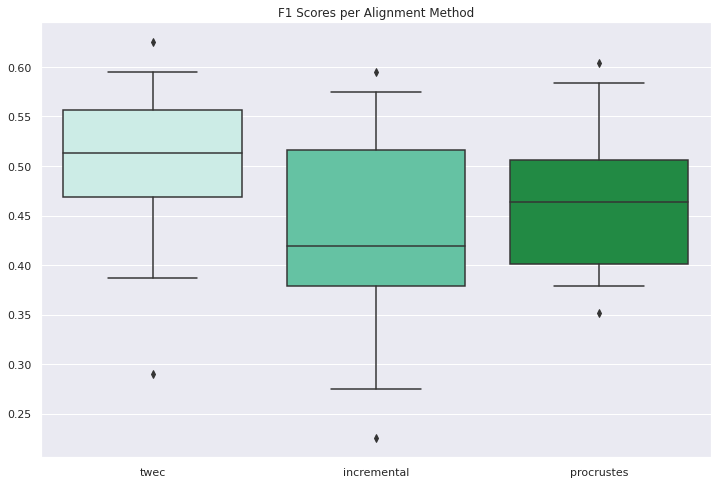

In [78]:
sns.set()
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot( saturation=1, palette='BuGn',ax=ax, whis=[5, 95],x=mapping_df['mapping'],y=mapping_df['accuracy_score'])
# specify axis labels
plt.xlabel('', size=14, family='monospace')
plt.ylabel('', size=14, family='monospace')
plt.title('F1 Scores per Alignment Method')
plt.show()

## Research Questions
### 2. Do pretrained embeddings improve performance?

### Null Hypothesis: 
Executions with pretrained embeddings perform equally with those that haven't been prior initialized.



In [79]:
# deep copy
pretrained_df = results_df.copy(deep=True)
# remove executions without pretrained embeddings
pretrained_df = pretrained_df.drop(pretrained_df[((pretrained_df['mapping'] == 'twec') 
                                         | (pretrained_df['w2vec_algorithm'] == 'lda2vec'))].index)
                                         
# remove unnecessary columns
pretrained_df = pretrained_df.drop(['mapping'],axis=1)

pretrained_df = pretrained_df.melt(id_vars=["language", "w2vec_algorithm","pretrained"], 
        var_name="metric", 
        value_name="accuracy_score")


# remove rows with Nan values at f1_scores 
pretrained_df = pretrained_df[pretrained_df['accuracy_score'].notna()]

# remove unnecessary columns
pretrained_df = pretrained_df.drop('metric',axis=1)

print(pretrained_df.count(),"\n")
print(pretrained_df.head())

language           64
w2vec_algorithm    64
pretrained         64
accuracy_score     64
dtype: int64 

  language w2vec_algorithm  pretrained  accuracy_score
0      lat            sgns        None        0.275000
1       en            sgns        None        0.486486
3       de            cbow        None        0.354167
4       en            cbow       glove        0.432432
6      swe            cbow  sweconll17        0.677419


### 2.1 Shapiro-Wilk Test (checks normality of distribution)

In [80]:
# Shapiro-Wilk test
from collections import defaultdict
from scipy import stats

alpha =0.05

print("Shapiro-Wilk test for normal distribution: \n")
embedding_normality_dict = defaultdict()
for embedding in embeddings:
    if embedding == 'None':
        stat, p = stats.shapiro( pretrained_df.loc[pretrained_df['pretrained'] == 'None','accuracy_score'])
    else:
        stat, p = stats.shapiro( pretrained_df.loc[pretrained_df['pretrained'] != 'None','accuracy_score'])
    print(embedding)
    if p >= alpha:
        print("\t has a normal distribution with pvalue = "+ str(p) + ", stat=",str(stat))
        embedding_normality_dict[embedding] = True
    else:
        print("\t has NOT a normal distribution with pvalue = ", p, "stat=",stat)
        embedding_normality_dict[embedding] = False
        

Shapiro-Wilk test for normal distribution: 

pretrained
	 has a normal distribution with pvalue = 0.7074304223060608, stat= 0.9769535064697266
None
	 has a normal distribution with pvalue = 0.5168358087539673, stat= 0.9706252217292786


### Normality Results
Executions with usage of **Pretrained** embeddings and **Non Pretained** embeddings can be described by the normal distribution.

The next step is to conduct a **paired-T test**.</u>

### 2.2 Paired T-Test (parametric - normality is  a prerequisite)
- Prerequisites:

    - normal distribution of dependent variable
    - continuous dependent variable
    - independent observations 
    - same subject for each group 
    - dependent variable does not contain outliers. 
  
- H0: means of the populations are equal to zero
* H1: p1 is not equal to p2  || p1 – p2 is not equal to zero.

**Samples are paired** since all variables except the under investigation variable are shared among the different populations



In [81]:
# Ensure we don't have any outliers
# IQR
Q1 = np.percentile(pretrained_df.loc[(pretrained_df['pretrained'] != 'None'), ['accuracy_score']], 
                   25,interpolation = 'midpoint')
 
Q3 = np.percentile(pretrained_df.loc[(pretrained_df['pretrained'] != 'None'), ['accuracy_score']], 
           75,interpolation = 'midpoint')

IQR = Q3 - Q1


# Above Upper bound
upper = pretrained_df['accuracy_score'] >= (Q3+1.5*IQR)
# Below Lower bound
lower = pretrained_df['accuracy_score'] <= (Q1-1.5*IQR)

if (upper == True).any():
    upper_outliers = lower.loc[lower == True].index.tolist()
    print("upper_outliers:",upper_outliers)
    #print(np.where(upper))
elif (lower == True).any():
    lower_outliers = lower.loc[lower == True].index.tolist()
    print("lower_outliers:",lower_outliers)
    #print(np.where(lower))

print(pretrained_df[pretrained_df.index.isin(lower_outliers)])

pretrained_df = pretrained_df.drop(pretrained_df[((pretrained_df['language'] == 'swe'))].index)


    language w2vec_algorithm  pretrained  accuracy_score
52       swe            cbow        None        0.225806
105      swe            cbow  sweconll17        0.354839


/tmp/ipykernel_35762/3832175542.py:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q1 = np.percentile(pretrained_df.loc[(pretrained_df['pretrained'] != 'None'), ['accuracy_score']],
/tmp/ipykernel_35762/3832175542.py:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q3 = np.percentile(pretrained_df.loc[(pretrained_df['pretrained'] != 'None'), ['accuracy_score']],


In [82]:
# Paired T-Test (parametric - normality is not a prerequisite)
# Compare groups of incremental, procrustes and twec

alpha =0.05

print("Paired T-Test H-test: \n\n pretrained - NOT pretrained")
stat, p = stats.ttest_rel(
    pretrained_df.loc[pretrained_df['pretrained'] != 'None','accuracy_score'],
    pretrained_df.loc[pretrained_df['pretrained'] == 'None','accuracy_score'])

if p < alpha:
    print("    Null Hypothesis REJECTED with pvalue = ", p, "stat=",stat)
else:
    print("    Null hypothesis was ACCEPTED with pvalue = ",p, "stat=",stat)

Paired T-Test H-test: 

 pretrained - NOT pretrained
    Null Hypothesis REJECTED with pvalue =  0.014146191893117997 stat= 2.655073402500333


In [83]:
# check percentage of increase
none_mean = pretrained_df.loc[pretrained_df['pretrained'] == 'None'].mean()[0]
pretrained_mean = pretrained_df.loc[pretrained_df['pretrained'] != 'None'].mean()[0]

increase_percentage = str(round(((pretrained_mean-none_mean)/none_mean)*100))
print("Pretrained embeddings perform better with an increase of ", increase_percentage + '%')



Pretrained embeddings perform better with an increase of  15%


/tmp/ipykernel_35762/1886954407.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  none_mean = pretrained_df.loc[pretrained_df['pretrained'] == 'None'].mean()[0]
/tmp/ipykernel_35762/1886954407.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pretrained_mean = pretrained_df.loc[pretrained_df['pretrained'] != 'None'].mean()[0]


### 2.3 Results
After the execution on the following combinations:
- **cbow-sgns** (algorithm)
- **incremental-procrustes** (alignment)
- **en-de-lat** (languages)
- **cd-ln** (metrics of cosine distance and local_neighborhood measure)
- **pretrained - not pretrained** (usage of pretrained embeddings)

Half of the models' vector weights were prior initialized with pretrained embeddings e.g. glove.

On the following **Word2Vec** parameter setting:
- **embeddings_dimension = 100**
- **window_size = 10**
- **min_count = 3** (number of occurences)
- **s = 0.001** (threshold for configuring which higher-frequency words are randomly downsampled)
- **k = 5** number of negative samples parameter 
- **epochs = 5**


We investigated the f1_scores of **48 executions** (algorithms * alignmen * languages * metrics).

The result was that **there are significate differences** between the model which were prior initialized and those hadn't.

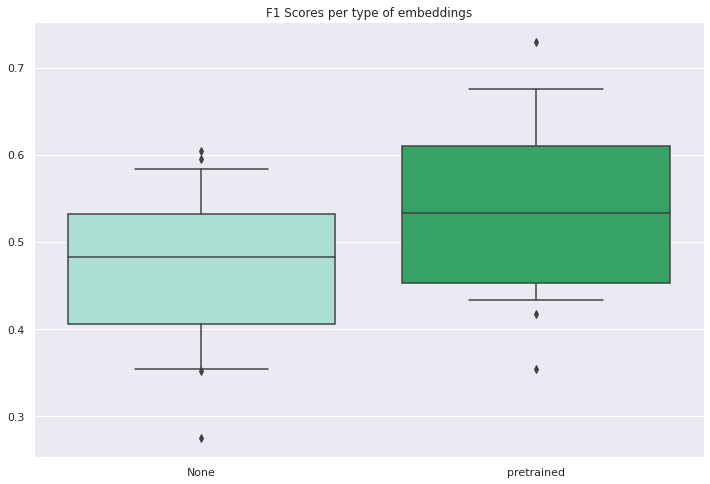

In [85]:
sns.set()
fig, ax = plt.subplots(figsize=(12,8))

pretrained_df.loc[pretrained_df["pretrained"] != "None", "pretrained"] = "pretrained"
sns.boxplot( saturation=1, palette='BuGn',ax=ax, whis=[5, 95],x=pretrained_df['pretrained'],y=pretrained_df['accuracy_score'])
# specify axis labels
plt.xlabel('', size=14, family='monospace')
plt.ylabel('', size=14, family='monospace')
plt.title('F1 Scores per type of embeddings')
plt.show()

## Research Questions
### 3. Lda2Vec and word2vec models performs the same?

### Null Hypothesis: 
Executions with lda2vec equally perform with those from a word2vec across different executions on the same datasets and parameters.


In [93]:
# deep copy
model_df = results_df.copy(deep=True)

# remove word2vec "pretrained" executions 
# since lda2vec does not contain exections with pretrained
model_df = model_df.drop(model_df[((model_df['pretrained'] != 'None') )].index)
                                         
# remove unnecessary columns
model_df = model_df.drop(['pretrained'],axis=1)

# 'f1_cd','f1_ln' columns to row info into the newly created metric column
model_df = model_df.melt(id_vars=["language", "w2vec_algorithm","mapping"], var_name="metric", value_name="accuracy_score")

# remove rows with Nan values at f1_scores 
# it stands for the execution of e.g 'f1_cd' where 'f1_ln' was Nan 
model_df = model_df[model_df['accuracy_score'].notna()]

print("model_df_1: ",model_df)

# transform cbow/sgns to word2vec
#model_df["w2vec_algorithm"] = np.where(model_df["w2vec_algorithm"] == "lda2vec", 'lda2vec', 'word2vec')

print("model_df_2: ",model_df)

# keep experiments with same mapping method of lda2vec and word2vec
model_df = model_df[(model_df['mapping'] == 'procrustes') ]

print("model_df_3: ",model_df)

# keep experiments with same language
# we have execution only from 'english' and 'latin'
model_df = model_df[model_df['language'].isin(['en','lat'])]

# remove unnecessary columns
#model_df = model_df.drop('metric',axis=1)

print(model_df)

model_df_1:      language w2vec_algorithm      mapping       metric  accuracy_score
0        lat            cbow         twec  accuracy_cd        0.575000
1        lat            sgns  incremental  accuracy_cd        0.275000
2         en            sgns   procrustes  accuracy_cd        0.486486
4         de            cbow  incremental  accuracy_cd        0.354167
5        lat         lda2vec   procrustes  accuracy_cd        0.400000
6         en            cbow   procrustes  accuracy_cd        0.378378
9         en            cbow         twec  accuracy_cd        0.405405
11        de            cbow   procrustes  accuracy_cd        0.583333
12        de            sgns         twec  accuracy_cd        0.479167
13       lat            sgns         twec  accuracy_cd        0.550000
14       lat            cbow   procrustes  accuracy_cd        0.475000
15       swe            sgns  incremental  accuracy_cd        0.387097
17        en         lda2vec   procrustes  accuracy_cd        0.

### 3.1 Shapiro-Wilk Test (checks normality of distribution)

In [94]:
# Shapiro-Wilk test
from collections import defaultdict
from scipy import stats

alpha = 0.05

print("Shapiro-Wilk test for normal distribution: \n")
model_normality_dict = defaultdict()
for w2vec_algorithm in w2vec_algorithms:
    print(w2vec_algorithm)
    stat, p = stats.shapiro( model_df.loc[model_df['w2vec_algorithm'] == w2vec_algorithm,'accuracy_score'])
        
    if p >= alpha:
        print("\t has a normal distribution with pvalue = "+ str(p) + ", stat=",str(stat))
        model_normality_dict[mapping] = True
    else:
        print("\t has NOT a normal distribution with pvalue = ", p, "stat=",stat)
        model_normality_dict[mapping] = False

Shapiro-Wilk test for normal distribution: 

cbow
	 has a normal distribution with pvalue = 0.38038206100463867, stat= 0.8894097805023193
sgns
	 has a normal distribution with pvalue = 0.6174443364143372, stat= 0.9338897466659546
lda2vec
	 has a normal distribution with pvalue = 0.3926840126514435, stat= 0.8920566439628601


### Normality Results
**Word2Vec** models can be described by the normal distribution.

However since **Lda2Vec** method does not meet the criteria of the normality <u>we have to go through with non parapetric tests.</u>

### 3.2 Wilcoxon Signed-Rank Test (non parametric - normality is not a prerequisite)
* Prerequisites (non normal distributions, paired samples, two populations)
* Samples are paired since all variables except the under investigation variable are shared among the different populations
* H0: Populations have same distributions


In [95]:
# Wilcoxon Signed-Rank Test (non parametric - normality is not a prerequisite)
# Compare groups of incremental, procrustes and twec

alpha =0.05
print("Wilcoxon Signed-Rank H-test")

for w2vec_algorithm in w2vec_algorithms:
    if w2vec_algorithm!='lda2vec':
        print("lda2vec-",w2vec_algorithm)
        stat, p = stats.ttest_rel(
            model_df.loc[model_df['w2vec_algorithm'] == 'lda2vec','accuracy_score'],
            model_df.loc[model_df['w2vec_algorithm'] == w2vec_algorithm,'accuracy_score'])

        if p < alpha:
            print("    Null Hypothesis REJECTED with pvalue = ", p, "stat=",stat)
        else:
            print("    Null hypothesis was ACCEPTED with pvalue = ",p, "stat=",stat)
    

Wilcoxon Signed-Rank H-test
lda2vec- cbow
    Null hypothesis was ACCEPTED with pvalue =  0.07110718331090769 stat= 2.7438656496750204
lda2vec- sgns
    Null hypothesis was ACCEPTED with pvalue =  0.4375608279508396 stat= 0.8931986429215097


### 3.3 Results
After the execution on the following combinations:
- **lda2vec-word2vec** (model)
- **procrustes**
- **en-lat** (languages)
- **cd-ln** (metrics of cosine distance and local_neighborhood measure)

On the following **Word2Vec** parameter setting:
- **embeddings_dimension = 100**
- **window_size = 10**
- **min_count = 3** (number of occurences)
- **s = 0.001** (threshold for configuring which higher-frequency words are randomly downsampled)
- **k = 5** number of negative samples parameter 
- **epochs = 5**

We investigated the f1_scores of **8 executions** (models * languages * metrics) of the lda2vec vs sgns and cbow executions.

The result was that **there are NOT significate differences** between the model which were prior initialized and those hadn't.
We need to mention that there were not executions with twec alignment method at the above analysis.

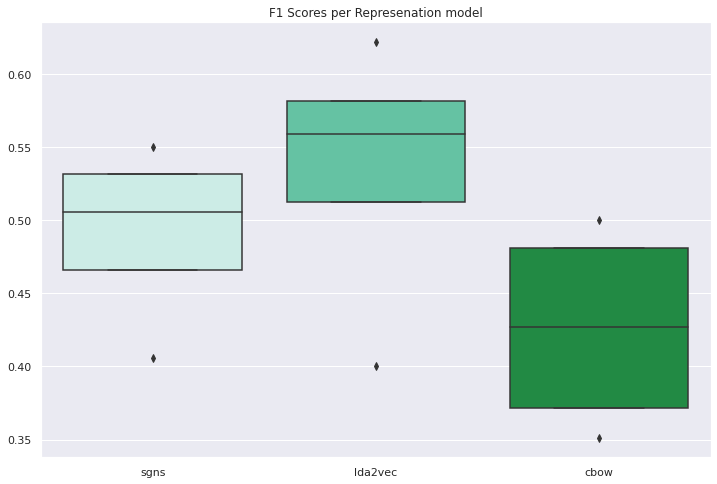

In [96]:
sns.set()
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot( saturation=1, palette='BuGn',ax=ax, whis=[5, 95],x=model_df['w2vec_algorithm'],y=model_df['accuracy_score'])
# specify axis labels
plt.xlabel('', size=14, family='monospace')
plt.ylabel('', size=14, family='monospace')
plt.title('F1 Scores per Represenation model')
plt.show()

## Results summary

We have seen that in our set up (parameter setting) and the limitations (low volume of training data) we found that:
1. There are **NO statistical significant** differences among the different methods of alignment
2. When models' weights are prior initialized with pretrained weights, there is a **statistical significant** difference with an increase of 16% on the median value.
3. There are **NO statistical significant** differences among the models of word2vec and lda2vec.
   However, an other finding is that the metric of local_neighborhood (LN) measure outstands cosine_distance(CD) f1_scores.
   mean(CD_lda2vec_f1_scores) --> 0,844
   mean(LN_lda2vec_f1_scores) --> 2,343
   percentage of increase: (2,343-0,844)/0,844= 170%

   **UNDER INVESTIGATION**

In [97]:
print(model_df.sort_values(by=['accuracy_score']))

    language w2vec_algorithm     mapping       metric  accuracy_score
96        en            cbow  procrustes  accuracy_ln        0.351351
6         en            cbow  procrustes  accuracy_cd        0.378378
5        lat         lda2vec  procrustes  accuracy_cd        0.400000
80        en            sgns  procrustes  accuracy_ln        0.405405
14       lat            cbow  procrustes  accuracy_cd        0.475000
2         en            sgns  procrustes  accuracy_cd        0.486486
73       lat            cbow  procrustes  accuracy_ln        0.500000
60       lat            sgns  procrustes  accuracy_ln        0.525000
22       lat            sgns  procrustes  accuracy_cd        0.550000
103      lat         lda2vec  procrustes  accuracy_ln        0.550000
76        en         lda2vec  procrustes  accuracy_ln        0.567568
17        en         lda2vec  procrustes  accuracy_cd        0.621622


KeyError: 'w2vec_algorithm'

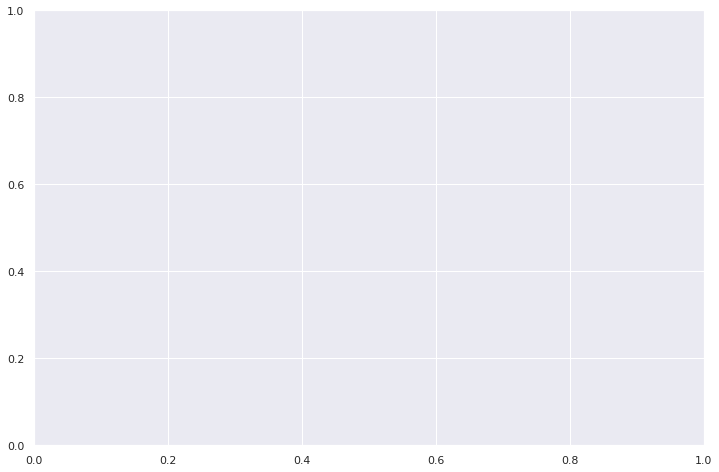

In [100]:
kati_df = model_df.loc[model_df['w2vec_algorithm'] == 'lda2vec','accuracy_score']

sns.set()
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot( saturation=1, palette='BuGn',ax=ax, whis=[5, 95],x=kati_df['w2vec_algorithm'],y=kati_df['accuracy_score'])
# specify axis labels
plt.xlabel('', size=14, family='monospace')
plt.ylabel('', size=14, family='monospace')
plt.title('F1 Scores per Represenation model')
plt.show()



## Results summary

We have seen that in our set up (parameter setting) and the limitations (low volume of training data) we found that:
1. There are **NO statistical significant** differences among the different methods of alignment
2. When models' weights are prior initialized with pretrained weights, there is a **statistical significant** difference with an increase of 16% on the median value.
3. There are **NO statistical significant** differences among the models of word2vec and lda2vec.
   However, an other finding is that the local_neighborhood (LN) measure outstands cosine_distance(CD) f1_scores.
   mean(CD_lda2vec_f1_scores) --> 0,844
   mean(LN_lda2vec_f1_scores) --> 2,343
   percentage of increase: (2,343-0,844)/0,844= 170%

   **UNDER INVESTIGATION**

In [102]:
print(model_df.loc[model_df['w2vec_algorithm'] == 'lda2vec','accuracy_score'])

5      0.400000
17     0.621622
76     0.567568
103    0.550000
Name: accuracy_score, dtype: float64


In [103]:
executions_df = pd.DataFrame(columns = ['w2vec_algorithm', 'metric','accuracy_score'])

executions_df.loc[count] = [key, dim, window, epoch,round(f1_score(docs_true, docs_pred),3),
                                        round(accuracy_score(docs_true, docs_pred),3),
                                        round(precision_score(docs_true, docs_pred),3),
                                        round(recall_score(docs_true, docs_pred),3)]


NameError: name 'key' is not defined

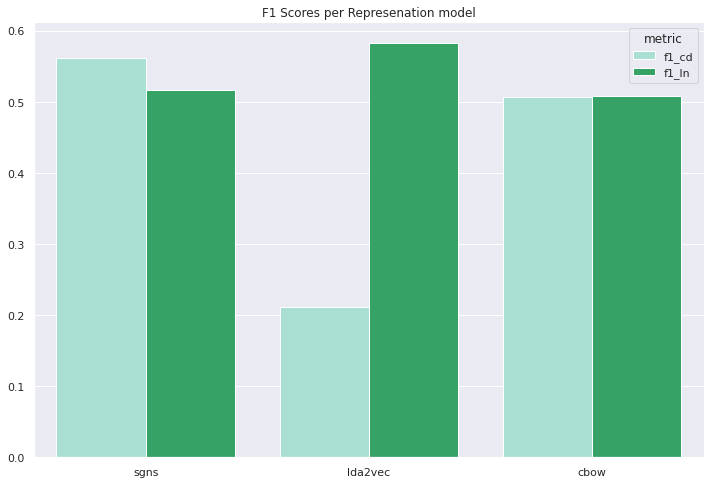

In [70]:
sns.set()
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(saturation=1,palette='BuGn',x = model_df['w2vec_algorithm'], y = model_df['f1_score'], ci = None,hue = "metric",data = model_df)
# specify axis labels
plt.xlabel('', size=14, family='monospace')
plt.ylabel('', size=14, family='monospace')
plt.title('F1 Scores per Represenation model')
plt.show()
